CNN


Epoch 1/20 - Train Loss: 1.0977, Train Acc: 0.5113, Val Loss: 0.7190, Val Acc: 0.7122
Epoch 2/20 - Train Loss: 0.6308, Train Acc: 0.7470, Val Loss: 0.5369, Val Acc: 0.7822
Epoch 3/20 - Train Loss: 0.5110, Train Acc: 0.8006, Val Loss: 0.4220, Val Acc: 0.8416
Epoch 4/20 - Train Loss: 0.4374, Train Acc: 0.8313, Val Loss: 0.3802, Val Acc: 0.8390
Epoch 5/20 - Train Loss: 0.3942, Train Acc: 0.8518, Val Loss: 0.3279, Val Acc: 0.8723
Epoch 6/20 - Train Loss: 0.3591, Train Acc: 0.8630, Val Loss: 0.3401, Val Acc: 0.8600
Epoch 7/20 - Train Loss: 0.3202, Train Acc: 0.8757, Val Loss: 0.3135, Val Acc: 0.8714
Epoch 8/20 - Train Loss: 0.2816, Train Acc: 0.8890, Val Loss: 0.2501, Val Acc: 0.9003
Epoch 9/20 - Train Loss: 0.2425, Train Acc: 0.9098, Val Loss: 0.2394, Val Acc: 0.9064
Epoch 10/20 - Train Loss: 0.2301, Train Acc: 0.9170, Val Loss: 0.2301, Val Acc: 0.9055
Epoch 11/20 - Train Loss: 0.2307, Train Acc: 0.9122, Val Loss: 0.2275, Val Acc: 0.9099
Epoch 12/20 - Train Loss: 0.2243, Train Acc: 0.9149,

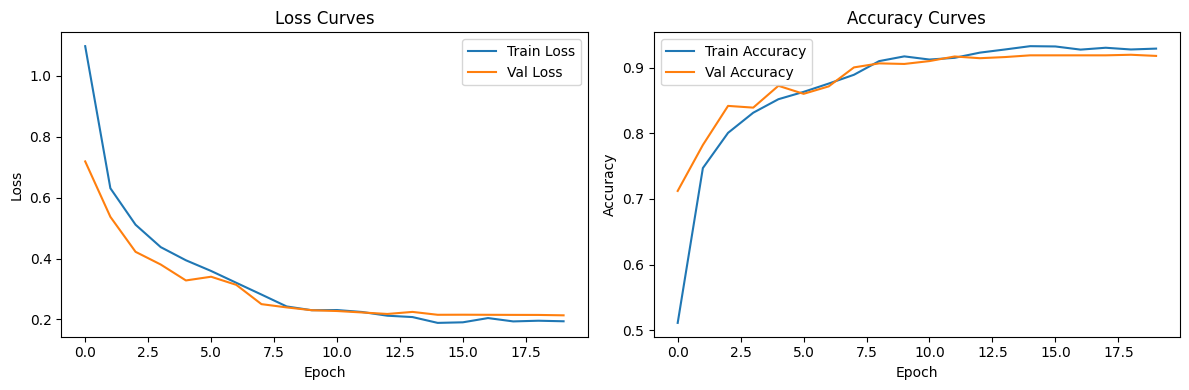

Test Accuracy: 0.9062


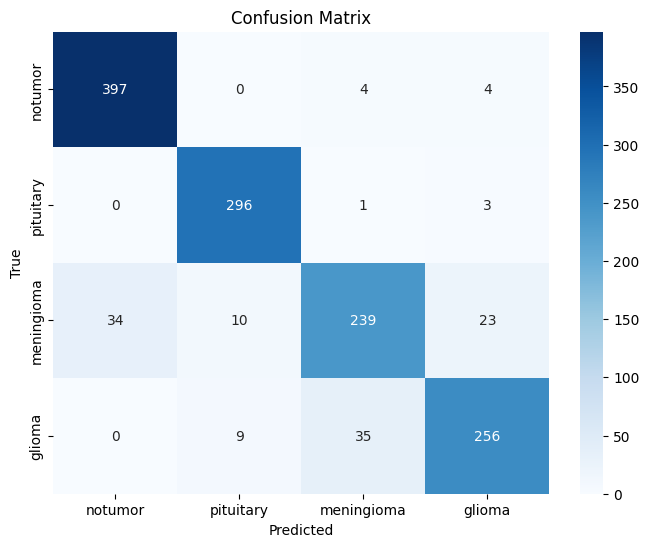

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset path
USER_PATH = r"/kaggle/input/brain-tumor-mri-dataset"

# Custom Dataset
class BrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_map = {'notumor': 0, 'pituitary': 1, 'meningioma': 2, 'glioma': 3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.label_map[self.dataframe.iloc[idx]['label']]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# CBAM Block
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, 1)
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, 1)
        self.sigmoid_channel = nn.Sigmoid()

        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.bn_spatial = nn.BatchNorm2d(1)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        # Channel Attention
        avg_out = self.fc2(self.fc1(self.avg_pool(x)))
        max_out = self.fc2(self.fc1(self.max_pool(x)))
        channel_out = self.sigmoid_channel(avg_out + max_out)
        x = x * channel_out

        # Spatial Attention
        avg_spatial = torch.mean(x, dim=1, keepdim=True)
        max_spatial, _ = torch.max(x, dim=1, keepdim=True)
        spatial = torch.cat([avg_spatial, max_spatial], dim=1)
        spatial_out = self.sigmoid_spatial(self.bn_spatial(self.conv_spatial(spatial)))
        x = x * spatial_out

        return x

# Custom CNN with CBAM after each conv block
class CNN_CBAM(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN_CBAM, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            CBAM(32),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            CBAM(64),
            nn.MaxPool2d(2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            CBAM(128),
            nn.MaxPool2d(2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            CBAM(256),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.classifier(x)
        return x

# Load dataset from folders
def load_dataset(path):
    data = []
    for split in ['Training', 'Testing']:
        split_path = os.path.join(path, split)
        for tumor_type in os.listdir(split_path):
            tumor_path = os.path.join(split_path, tumor_type)
            if os.path.isdir(tumor_path):
                for img_name in os.listdir(tumor_path):
                    if img_name.endswith(('.jpg', '.png', '.jpeg')):
                        data.append({
                            'image_path': os.path.join(tumor_path, img_name),
                            'label': tumor_type,
                            'split': split
                        })
    return pd.DataFrame(data)

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load and split data
data = load_dataset(USER_PATH)
train_data = data[data['split'] == 'Training']
test_data = data[data['split'] == 'Testing']
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label'], random_state=42)

# Create datasets
train_dataset = BrainTumorDataset(train_data, transform=train_transform)
val_dataset = BrainTumorDataset(val_data, transform=test_transform)
test_dataset = BrainTumorDataset(test_data, transform=test_transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=112, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=112, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=112, shuffle=False)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_CBAM(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

# Plot training and validation performance
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate on test set
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['notumor', 'pituitary', 'meningioma', 'glioma'],
                yticklabels=['notumor', 'pituitary', 'meningioma', 'glioma'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Final Evaluation
evaluate_model(model, test_loader)
